<center><h1>Saliency Estimation Experiment - DeepGazeIIE - Pascal VOC dataset</h1>
<h2>Matthias Bartolo</h2>

</center>

  0%|          | 0/52 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
  2%|▏         | 1/52 [00:04<03:34,  4.22s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
  4%|▍         | 2/52 [00:10<04:42,  5.65s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
  6%|▌         | 3/52 [00:17<05:03,  6.19s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
  8%|▊         | 4/52 [00:24<05:01,  6.28s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 10%|▉         | 5/52 [00:31<05:06,  6.52s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 12%|█▏        | 6/52 [00:42<06:16,  8.19s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 13%|█▎        | 7/52 [00:49<05:48,  7.74s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 15%|█▌        | 8/52 [00:52<04:33,  6.22s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 17%|█▋        | 9/52 [00:55<03:41,  5.15s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 19%|█▉        | 10/52 [00:57<03:03,  4.37s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 21%|██        | 11/52 [01:00<02:37,  3.85s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 23%|██▎       | 12/52 [01:03<02:20,  3.51s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 25%|██▌       | 13/52 [01:05<02:06,  3.24s/it]

Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.6.0
 25%|██▌       | 13/52 [01:08<03:25,  5.27s/it]


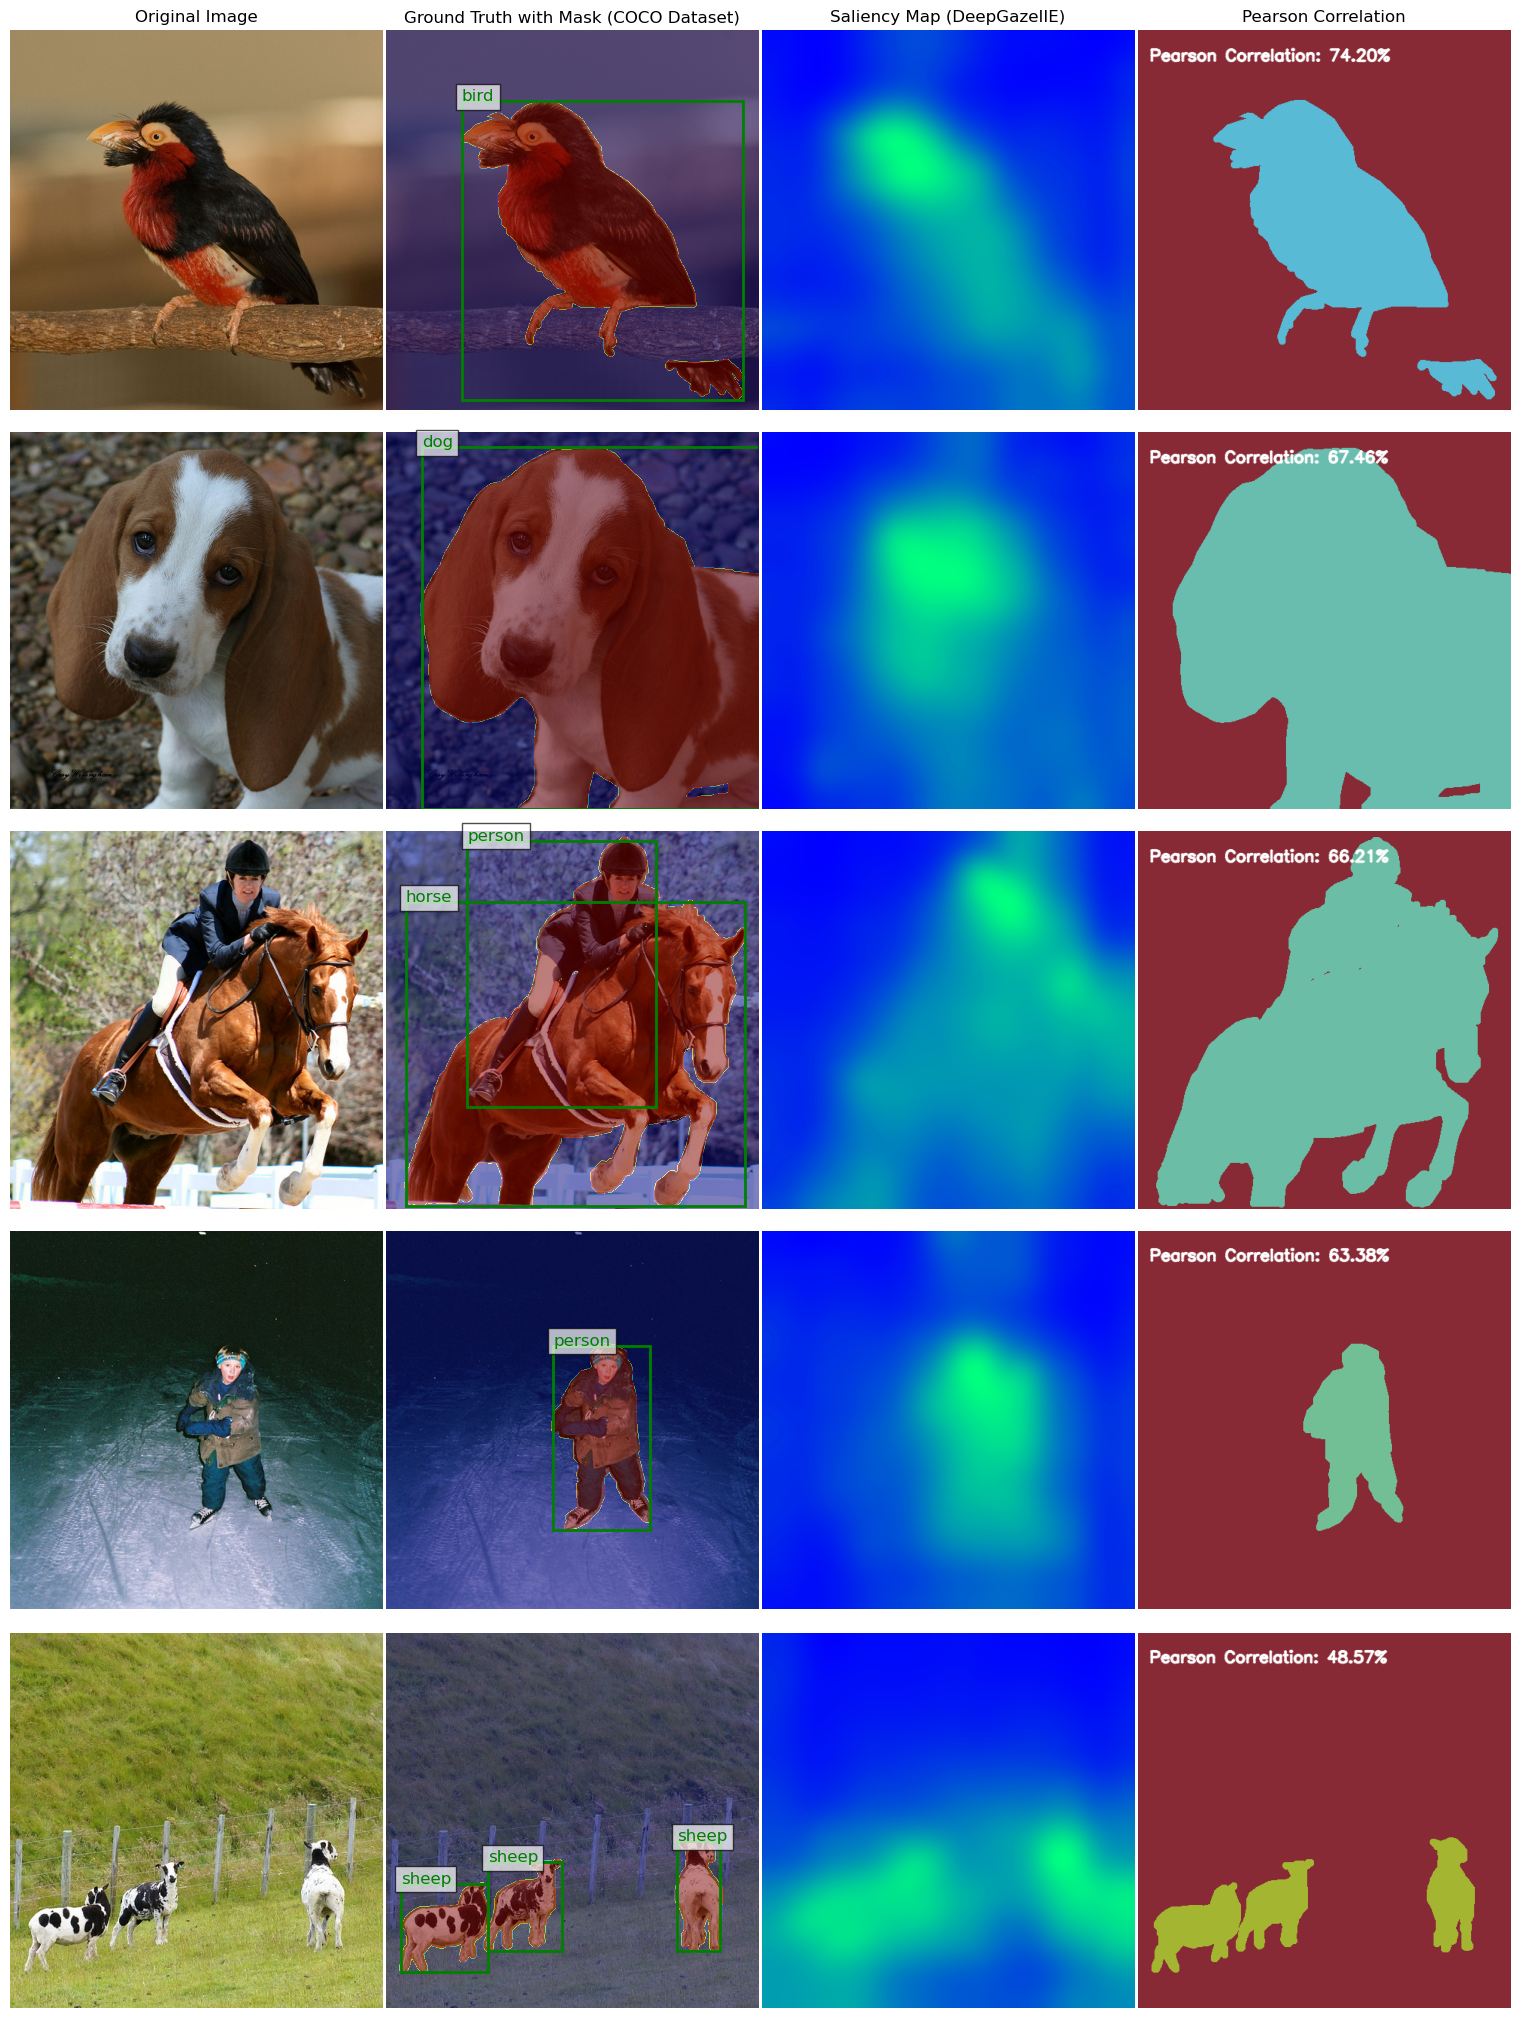

In [1]:
import os
import xml.etree.ElementTree as ET
from transformers import pipeline
from PIL import Image
import torch
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")

import SaRa.saraRC1 as sara
GENERATORS = ['itti', 'deepgaze']
generator = 'deepgaze'

# PASCAL VOC paths
voc_root = "PascalVOC2012Dataset/VOCdevkit/VOC2012"
image_folder = os.path.join(voc_root, "JPEGImages")
annotation_folder = os.path.join(voc_root, "Annotations")

# Function to extract object masks, bounding boxes, and category labels from PASCAL VOC dataset
def get_voc_masks_and_category(image_id):
    # Define paths to annotations and segmentation masks
    annotation_path = os.path.join(annotation_folder, f"{image_id}.xml")
    segmentation_path = os.path.join(voc_root, "SegmentationClass", f"{image_id}.png")

    # Parse the annotation XML to get bounding boxes and categories
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    bboxes = []
    categories = []

    # Iterate over all object elements in the XML
    for obj in root.findall("object"):
        category_name = obj.find("name").text
        bndbox = obj.find("bndbox")

        xmin = int(float(bndbox.find("xmin").text))
        ymin = int(float(bndbox.find("ymin").text))
        xmax = int(float(bndbox.find("xmax").text))
        ymax = int(float(bndbox.find("ymax").text))

        # Create a bounding box [x, y, width, height]
        bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
        bboxes.append(bbox)
        categories.append(category_name)

    # Load the segmentation mask for the image
    if os.path.exists(segmentation_path):
        # Load the mask as a NumPy array
        object_mask = np.array(Image.open(segmentation_path))
        # If the mask is in RGB, convert it to grayscale
        if object_mask.ndim == 3:
            object_mask = cv2.cvtColor(object_mask, cv2.COLOR_RGB2GRAY)
        # Create a binary mask: any non-zero pixel is considered object
        binary_mask = (object_mask > 0).astype(np.uint8)
    else:
        binary_mask = None

    return binary_mask, bboxes, categories

# Function to process a single image and return results for grid display
def process_image(image_file):
    # Load image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)

    # Perform saliency inference using SaRa
    image = np.array(image)
    sara_image = image.copy()
    sara.reset()

    saliency_map = sara.return_saliency(sara_image, generator=generator)

    # Convert image filename to image_id (without file extension)
    image_id = os.path.splitext(image_file)[0]

    # Get the object mask, bounding boxes, and category labels for the image from PASCAL VOC annotations
    object_mask, bboxes, categories = get_voc_masks_and_category(image_id)

    if object_mask is None:
        return None

    # Resize mask to match the depth map dimensions
    depth_map_resized = cv2.resize(np.array(saliency_map), (object_mask.shape[1], object_mask.shape[0]))

    # Flatten the object mask and depth map for Pearson correlation
    flattened_mask = object_mask.flatten()
    flattened_depth = depth_map_resized.flatten()

    # Pearson correlation between object mask and depth values
    correlation, _ = pearsonr(flattened_mask, flattened_depth)

    return image, object_mask, depth_map_resized, bboxes, categories, correlation

# Get list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle the image files and select 5 iamges with similar sizes
# np.random.shuffle(image_files)

# Pick the first image and then select images with similar sizes
image_file = image_files[0]
image_path = os.path.join(image_folder, image_file)
image = Image.open(image_path)
image_size = image.size

# Filter 5 images with similar sizes
target_width, target_height = image_size

image_files = [
    f for f in image_files
    if abs(Image.open(os.path.join(image_folder, f)).size[0] - target_width) <= 10 and
       abs(Image.open(os.path.join(image_folder, f)).size[1] - target_height) <= 10
]

# Only process 5 images for demonstration purposes (Sample from the images, and choose images with similar sizes)
selected_images = []
for image_file in tqdm(image_files):
    result = process_image(image_file)
    if result is not None:
        selected_images.append(result)
    if len(selected_images) == 5:
        break

# Sort images based on Pearson correlation
selected_images = sorted(selected_images, key=lambda x: x[-1], reverse=True)


# Create a 5x4 grid of images
fig, axes = plt.subplots(5, 4, figsize=(15, 25))

# Define column titles
column_titles = [
    "Original Image",
    "Ground Truth with Mask (COCO Dataset)",
    "Saliency Map (DeepGazeIIE)",
    "Pearson Correlation"
]

# Set column titles
for col, title in enumerate(column_titles):
    axes[0, col].set_title(title, fontsize=12)

for i, (image, object_mask, depth_map, bboxes, categories, correlation) in enumerate(selected_images):
    row = i
    # Original Image
    axes[row, 0].imshow(image)
    axes[row, 0].axis("off")

    # Ground Truth with Mask and Labels
    ax = axes[row, 1]
    ax.imshow(image)
    ax.imshow(object_mask, cmap="jet", alpha=0.5)  # Overlay mask with color
    for bbox in bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
    for j, bbox in enumerate(bboxes):
        x, y, width, height = bbox
        category = categories[j]
        ax.text(x, y, category, color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    ax.axis("off")

    # Depth Map
    axes[row, 2].imshow(depth_map, cmap="winter")
    axes[row, 2].axis("off")

    # Pearson Correlation Heatmap
    correlation_map = np.zeros_like(object_mask, dtype=float)
    correlation_map[object_mask == 1] = correlation
    # Add to the correlation map white text with the correlation value
    percentage_text = f"Pearson Correlation: {correlation * 100:.2f}%"
    # Change the correlation map to RGB by truning it into a green ehatmap
    correlation_map_rgb = cv2.applyColorMap((correlation_map * 255).astype(np.uint8), cv2.COLORMAP_PARULA)
    cv2.putText(correlation_map_rgb, percentage_text, (15, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    axes[row, 3].imshow(correlation_map_rgb, cmap="Greens", vmin=-1, vmax=1)
    axes[row, 3].axis("off")

# Adjust layout to remove extra space and fit titles
plt.subplots_adjust(left=0, right=1, top=0.8, bottom=0, wspace=0.01, hspace=0.001)
plt.show()


In [3]:
import os
import time
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm
from scipy.stats import pearsonr
import pandas as pd
import xml.etree.ElementTree as ET

import SaRa.saraRC1 as sara

# Constants
GENERATORS = ['itti', 'deepgaze']
generator = 'deepgaze'
BATCH_SIZE = 128
DEVICE = 'cuda'

# PASCAL VOC paths
voc_root = "PascalVOC2012Dataset/VOCdevkit/VOC2012"
image_folder = os.path.join(voc_root, "JPEGImages")
annotation_folder = os.path.join(voc_root, "Annotations")
segmentation_folder = os.path.join(voc_root, "SegmentationClass")

# Load category names from PASCAL VOC dataset
categories = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair",
    "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

# Create a mapping from category names to IDs
category_id_to_name = {i: name for i, name in enumerate(categories)}
category_name_to_id = {name: i for i, name in enumerate(categories)}

# Function to extract object masks and categories from PASCAL VOC dataset
def get_voc_masks_and_category(image_id):
    """Extract object masks and categories from PASCAL VOC dataset."""
    annotation_path = os.path.join(annotation_folder, f"{image_id}.xml")
    segmentation_path = os.path.join(segmentation_folder, f"{image_id}.png")

    if not os.path.exists(annotation_path):
        return None, None, None

    tree = ET.parse(annotation_path)
    root = tree.getroot()

    bboxes = []
    categories = []

    for obj in root.findall("object"):
        category_name = obj.find("name").text
        bndbox = obj.find("bndbox")

        xmin = int(float(bndbox.find("xmin").text))
        ymin = int(float(bndbox.find("ymin").text))
        xmax = int(float(bndbox.find("xmax").text))
        ymax = int(float(bndbox.find("ymax").text))

        bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
        bboxes.append(bbox)
        categories.append(category_name)

    if os.path.exists(segmentation_path):
        object_mask = np.array(Image.open(segmentation_path))
        if object_mask.ndim == 3:
            object_mask = cv2.cvtColor(object_mask, cv2.COLOR_RGB2GRAY)
        binary_mask = (object_mask > 0).astype(np.uint8)
    else:
        binary_mask = None

    return binary_mask, bboxes, categories

# Function to process a batch of images and generate saliency maps
def generate_saliency_maps_batch(image_files, deepgaze_model=None, emlnet_models=None, DEVICE='cuda', BATCH_SIZE=32, target_size=(224, 224)):
    batch_images = []
    image_ids = []
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        image = np.array(image)
        
        # Check if the image has 3 channels (RGB), otherwise convert it to 3 channels
        if len(image.shape) == 2:  # Grayscale image
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:  # If the image has an alpha channel (RGBA), remove it
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

        # Resize image to target size
        image_resized = cv2.resize(image, target_size)
        batch_images.append(image_resized)
        
        # Convert image filename to image_id
        image_ids.append(image_file.split('.')[0])

    # Perform saliency inference in batch using SaRa
    sara.reset()
    saliency_maps = sara.return_saliency_batch(batch_images, generator=generator, deepgaze_model=deepgaze_model, emlnet_models=emlnet_models, DEVICE=DEVICE, BATCH_SIZE=BATCH_SIZE)

    # Return a list of tuples (image_id, saliency_map)
    return list(zip(image_ids, saliency_maps))

# Function to process image batch and compute correlations
def process_image_batch(image_files):
    """Process a batch of images to compute Pearson correlation per category."""
    results = []
    
    # Generate saliency maps for the batch of images
    saliency_maps_list = generate_saliency_maps_batch(image_files, DEVICE=DEVICE, BATCH_SIZE=BATCH_SIZE)
    
    for image_id, saliency_map in saliency_maps_list:
        binary_mask, bboxes, categories = get_voc_masks_and_category(image_id)
        
        # If binary_mask is None, generate one from bounding boxes
        if binary_mask is None:
            # Load the image to get its dimensions
            image_path = os.path.join(image_folder, f"{image_id}.jpg")  # Assuming .jpg, adjust if necessary
            image = Image.open(image_path)
            image = np.array(image)
            
            # Get image dimensions
            height, width = image.shape[:2] if image.ndim == 3 else image.shape
            
            # Create an empty binary mask of the same size
            binary_mask = np.zeros((height, width), dtype=np.uint8)
            
            # Fill the mask using the bounding boxes
            for bbox in bboxes:
                x, y, bbox_width, bbox_height = bbox
                binary_mask[y:y + bbox_height, x:x + bbox_width] = 1  # Mark the region inside the bounding box as 1

        # Resize the saliency map to match the mask size
        depth_map_resized = cv2.resize(np.array(saliency_map), (binary_mask.shape[1], binary_mask.shape[0]))

        # Compute Pearson correlation for each category
        for category_name in set(categories):
            mask = (binary_mask > 0).astype(np.uint8)
            flattened_mask = mask.flatten()
            flattened_depth = depth_map_resized.flatten()

            # Compute Pearson correlation between the mask and the depth map
            correlation, _ = pearsonr(flattened_mask, flattened_depth)
            
            # Append the results
            results.append({
                'image_id': image_id,
                'category_id': category_name_to_id[category_name],
                'category_name': category_name,
                'correlation': correlation
            })

    return results

# Main script
start_time = time.time()

# Get list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Process all images in batches
all_results = []
for i in tqdm(range(0, len(image_files), BATCH_SIZE)):
    batch_files = image_files[i:i + BATCH_SIZE]
    batch_results = process_image_batch(batch_files)
    all_results.extend(batch_results)

end_time = time.time()

# Print the total processing time in minutes
print(f"Total processing time: {(end_time - start_time) / 60:.2f} minutes")

# Convert to DataFrame for easier manipulation
df_results = pd.DataFrame(all_results)

# Group by category and calculate mean correlation for each category
category_mean_correlation = df_results.groupby('category_name')['correlation'].mean().reset_index()

# Calculate the overall mean correlation across all images and categories
overall_mean_correlation = df_results['correlation'].mean()

# Display overall and per-category mean correlations
print(f"Overall mean depth-object correlation: {overall_mean_correlation:.2f}\n")
print("Mean depth-object correlation per category:")
print(category_mean_correlation.to_string(index=False))

# Display the table of correlations for individual images and categories
table = df_results[['image_id', 'category_name', 'correlation']].to_string(index=False, header=["Image ID", "Category", "Pearson Correlation"])
print("\nTable of Correlations per Image and Category:\n")
print(table)


In [2]:
# Save the table of correlations
table_file = "correlation_table.csv"

df_results.to_csv(table_file, index=False)
print(f"\nCorrelation table saved to: {table_file}")

# Save the overall and per-category mean correlations in csv format
mean_correlation_file = "mean_correlations.csv"

mean_correlation_df = pd.DataFrame({
    'category_name': ['Overall'] + category_mean_correlation['category_name'].tolist(),
    'mean_correlation': [overall_mean_correlation] + category_mean_correlation['correlation'].tolist()
})

# Sort by mean correlation
mean_correlation_df = mean_correlation_df.sort_values(by='mean_correlation', ascending=False)

mean_correlation_df.to_csv(mean_correlation_file, index=False)
# Overall,0.45877056254371235
# Time-Taken,716sec


Correlation table saved to: correlation_table.csv
